In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as ran
import scipy.optimize as opt
import scipy.stats as stat
import pandas as pd
import astropy as ap
from astropy import coordinates as coord
from astropy import units as u
from astropy.time import Time


In [44]:
#Three peaks and a linear fitting function for one of the data files 
def triplegaussfit(x,*p):
    return (p[0] + p[1]*x) + \
    (p[2]*(1/(p[3]*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-p[4])/p[3])**2)))) + \
    (p[5]*(1/(p[6]*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-p[7])/p[6])**2)))) + \
    (p[8]*(1/(p[9]*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-p[10])/p[9])**2))))

#The fitting function: a negatively sloped linear and two Gaussian functions
def radiofit(x, *p):
    return (p[0] + p[1]*x) + \
    (p[2]*(1/(p[3]*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-p[4])/p[3])**2)))) + \
    (p[5]*(1/(p[6]*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-p[7])/p[6])**2))))



In [45]:
def fit_and_plot(x,y,dy,fitfunction,gparams,plot_xlabel,plot_ylabel,xrange=[-1,-1],yrange=[-1,-1],make_image=0):
    
    #Plot the data points with error bars.  First set up the parameters of the plot, 
    #including default reasonable x and y ranges:
    plt.rcParams["figure.figsize"] = (20, 4)
    plt.xlabel(plot_xlabel, fontsize = '15')
    plt.ylabel(plot_ylabel, fontsize = '15')
        
    #if not given ranges of axes, fit them nicely to the data:
    if yrange==[-1,-1]:
        yspan=max(y)-min(y)
        yrange=[min(y)-yspan/10.,max(y)+yspan/10.]
    if xrange==[-1,-1]:
        xspan=max(x)-min(x)
        xrange=[min(x)-xspan/10.,max(x)+xspan/10.]
    plt.xlim(xrange)
    plt.ylim(yrange)
    
    #Now plot the data and error bars:
    plt.errorbar(x,y,yerr=dy,ls='none',fmt='.',ecolor = 'b', elinewidth = 0.6)
    #Now do the fit.  The two things on the left of the = sign (what is returned by the 
    #function opt.curve_fit) are the best values of the parameters and the covariance matrix
    #associated with the parameters.  The errors on the parameters are the square root of the
    #diagonal elements of the covariance matrix.  Print out the fitted parameters and their errors.
    #"absolute_sigma" means "really believe me that my 'sigma' are my real error bars."
    #"p0" is the original guesses at the fit parameters. The first three arguments are the name
    #of the fit function (defined above) and the x and y data values.
    xsmooth1 = np.linspace(np.min(x), np.max(x), 1000)
    plt.plot(xsmooth1, fitfunction(xsmooth1,*gparams), color = 'red')
    
    popt, pcov = opt.curve_fit(fitfunction, x, y, sigma=dy, p0=gparams,absolute_sigma=1)
    for i in range(0,len(popt)):
        print('param ',i,' = ',popt[i], '+/-', np.sqrt(pcov[i,i]))

    #Now prepare and plot what the fitted function looks like with the best parameters (in orange):
    fsmooth2 = fitfunction(xsmooth1,*popt)
    plt.plot(xsmooth1,fsmooth2,color='orange')

    #Calculate the actual value of chi-square for hypothesis testing.
    #Note: it is kind of sad that curve_fit doesn't return this, the
    #equivalent routine in most languages does.  "dof" = degrees of freedom.
    #Here we show two interpretations of the hypothesis test.
    
    yfit= fitfunction(x,*popt)
    chisq = sum( (y-yfit)**2 / dy**2 )
    dof = len(x) - len(popt)
    chisq_reduced = chisq/float(dof)
    print ('-----------------------------------------------------------------------------------------------------------------')
    print(f'Chi-square: {chisq}')
    print(f'degrees of freedom: {dof}')
    print(f'reduced chi-square: {chisq_reduced}')
    print('Probability of exceeding this chi-square by chance for correct model: ',1.-stat.chi2.cdf(chisq,dof))
    print('With what confidence can we reject this model? ',stat.chi2.cdf(chisq,dof))
    print ('-----------------------------------------------------------------------------------------------------------------')

    if make_image>0:
        plt.savefig('leastsquare.png', format='png')
    plt.title('Optimized Fitting Function', fontsize = '20')
    plt.show()

In [40]:
#Constants and other thigns to declare
f0 = 1420.4 *10**6         #frequency in Hz of the radio line
RBW = 30000                #Resolution Bandwidth in Hz
LNA = 37                   #LNA gain in decibels (dB)
CableAtten = 3             #Cable Attentuation in decibels (dB)
c = 3* 10**5               #speed of light in km/s
B = 0.5                    #Beta for brightness function 
k_B = 1.380649 * 10**(-23) #Boltzmann constant
plot_xlabel = 'Relative Velocity (km/s)'
plot_ylabel = 'Amplitude (W/Hz)'

## 101117.csv file

param  0  =  2.4545131295144474e-21 +/- 3.190812423448276e-24
param  1  =  -2.697802198000109e-25 +/- 2.222983294970665e-26
param  2  =  3.708446993970923e-21 +/- 5.225587184128784e-22
param  3  =  10.210604751054058 +/- 1.5337243124086253
param  4  =  -79.97531212194265 +/- 1.4628577241250953
param  5  =  1.1577327363689116e-20 +/- 1.7540344219634503e-21
param  6  =  11.098606360825084 +/- 0.9105275042862059
param  7  =  0.8623906637175918 +/- 1.3331835445842388
param  8  =  4.280963514196015e-21 +/- 1.9094842632614813e-21
param  9  =  15.40037210637217 +/- 6.315654690348174
param  10  =  -30.8350126565772 +/- 6.9081634378236165
-----------------------------------------------------------------------------------------------------------------
Chi-square: 329.26356589783865
degrees of freedom: 450
reduced chi-square: 0.7316968131063081
Probability of exceeding this chi-square by chance for correct model:  0.9999953164420803
With what confidence can we reject this model?  4.68355791972432

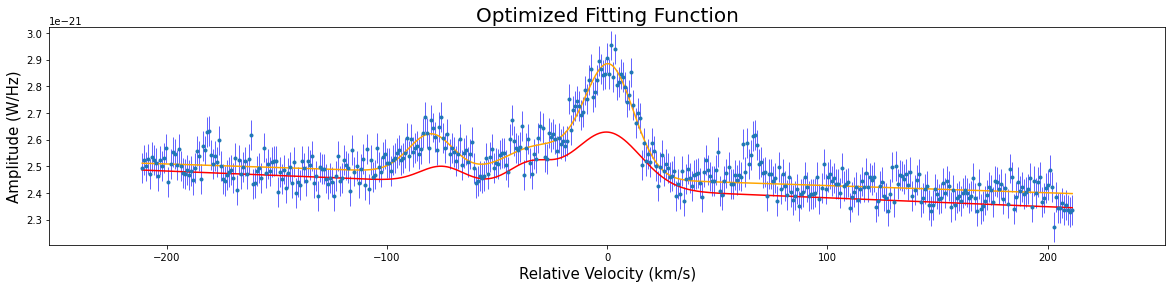

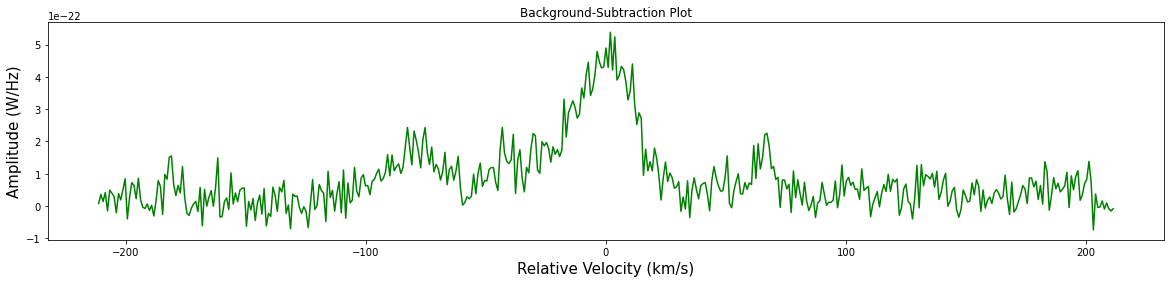

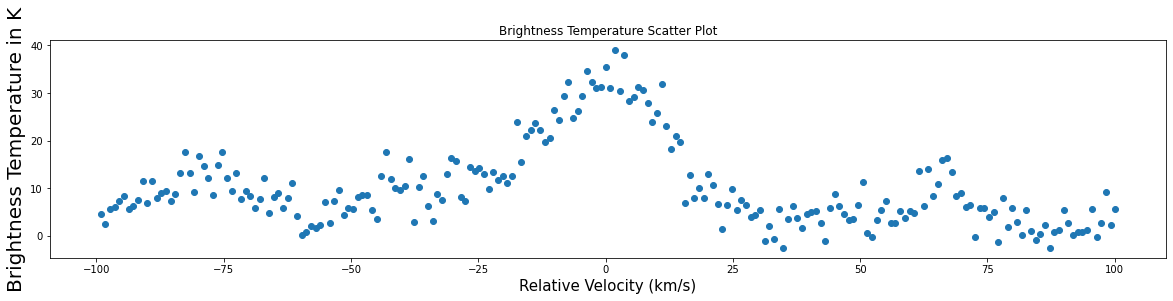

<SkyCoord (Galactic): (l, b) in deg
    (75.73023927, -0.51314595)>
-----------------------------------------------------------------------------------------------------------------
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (306.27615565, 36.91055227)>
-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------
The column density is 4.781815820468075e+21 cm^(-2)
-----------------------------------------------------------------------------------------------------------------
The column density from the NASA database is 8.22e+21 nH in cm^(-2)
The loss factor in our data is 1.7190122557240972
-----------------------------------------------------------------------------------------------------------------


In [49]:
#Reading the Data file using Pandas. 
#This is the main data file for analysis because it is least noisy
#Please edit the file directory for your device's storing locations
df = pd.read_csv('/Users/shashank/111017.csv', skiprows = 11)
temp_x = np.array(df['Frequecncy(Hz)'])
temp_y = np.array(df['Amplitude(dBm)'])

#Instrumental factors 
y_1 = temp_y - LNA + CableAtten
#unit conversion to W
y_2 = 10**(y_1/10)/1000 * 2 #conversion and accounting for polarization
#unit conversion to W/Hz
y   = y_2/RBW

#Frequency to Relative Line of Site velocity 
#Flips the axis (therefore a negatively sloping linear is used)
x = -c* ((temp_x/f0)-1)

#finding dy
subset = y[:167]
dy = y*0 + np.std(subset, ddof =1)

#Guess paramters
#Overall linear decline
offset            = (y[460]+y[0])/2
slope             = -np.std(subset)/len(subset)
#order of parameters: 
amplitude_left    = 1.5 * 10**(-21)                 #in W/Hz
width_left        = 10                            #in km/s
center_left       = -75                           #in km/s
#Gaussian middle
amplitude_right  = 8 * 10 **(-21)                 #in W/Hz
width_right      = 15                             #in km/s
center_right     = 0                              #in km/s
#mini-gauss
amplitude_middle = 2 * 10**(-21)                  #in W/Hz
width_middle     = 10                             #in km/s
center_middle    = -35                             #in km/s

gparams2 = np.array([offset, slope,
                    amplitude_left, width_left, center_left, 
                    amplitude_right, width_right, center_right,
                    amplitude_middle, width_middle, center_middle])

#Fitting with three gaussians for this one
fit_and_plot(x,y,dy,triplegaussfit,gparams2,plot_xlabel,plot_ylabel)

#background subtraction
background = gparams2
background[2] = 0.0
background[5] = 0.0
background[8] = 0.0
background_fit = triplegaussfit(x, *background)
corrected_y = y - background_fit     
plt.plot(x, corrected_y, color = 'g')
plt.xlabel(plot_xlabel, fontsize = '15')
plt.ylabel(plot_ylabel, fontsize = '15')
plt.title("Background-Subtraction Plot")
plt.show()

#brightness temperature
T = corrected_y/(2*k_B*B)
plt.scatter(x[121:339],T[121:339])
plt.xlabel(plot_xlabel, fontsize = '15')
plt.ylabel("Brightness Temperature in K", fontsize = '20')
plt.title("Brightness Temperature Scatter Plot")
plt.show()

#Calulating Declination and Right Ascension of where the antennae is pointing
utcoffset = -8 * u.hour
t = Time('2022-11-10 17:13:30') - utcoffset #The time is the middle of the five-minute window of collecting this data file
ucsc = coord.EarthLocation(lat=36.9881*u.deg,lon=-122.0582*u.deg)
thepoint = coord.SkyCoord(alt = 90*u.degree, az = 180*u.degree, obstime = t, frame = 'altaz', location = ucsc)
print(thepoint.galactic)
print ('-----------------------------------------------------------------------------------------------------------------')
print(thepoint.fk5) 
print ('-----------------------------------------------------------------------------------------------------------------')

#Column density
column_density = 0
for i in range(460):
    column_density = column_density + (T[i] * np.abs(x[i+1] - x[i]))
column_density = column_density + (T[460]*(x[460]-x[459]))
column_density = column_density*(1.8224 * 10**18)
print ('-----------------------------------------------------------------------------------------------------------------')
print (f'The column density is {column_density} cm^(-2)')
print ('-----------------------------------------------------------------------------------------------------------------')

#FROM NASA at the RA and Dec calculated before
NASA_column_density  =  8.22E+21
print (f'The column density from the NASA database is {NASA_column_density} nH in cm^(-2)' )
#Checking to see if there is an integer-like factor, that might account for losses
print (f'The loss factor in our data is {(NASA_column_density/column_density)}')
print ('-----------------------------------------------------------------------------------------------------------------')

## 101118.csv file

param  0  =  2.070140134144188e-21 +/- 3.0268403462816816e-24
param  1  =  -3.5082435433784e-25 +/- 2.0825171138064584e-26
param  2  =  9.118021774406793e-21 +/- 1.0462090122438777e-21
param  3  =  27.100467014803822 +/- 3.3943909255142493
param  4  =  -51.84593241997362 +/- 3.000674983778068
param  5  =  1.1883037992821864e-20 +/- 7.145335049972252e-22
param  6  =  11.00364066933512 +/- 0.5166757341104014
param  7  =  0.8033995845639427 +/- 0.4852313950472703
-----------------------------------------------------------------------------------------------------------------
Chi-square: 297.0179410621596
degrees of freedom: 453
reduced chi-square: 0.6556687440665775
Probability of exceeding this chi-square by chance for correct model:  0.9999999983156345
With what confidence can we reject this model?  1.6843654953579849e-09
-----------------------------------------------------------------------------------------------------------------


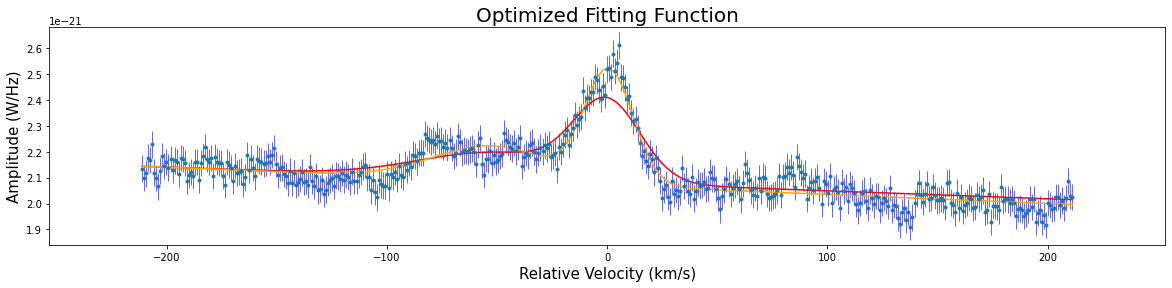

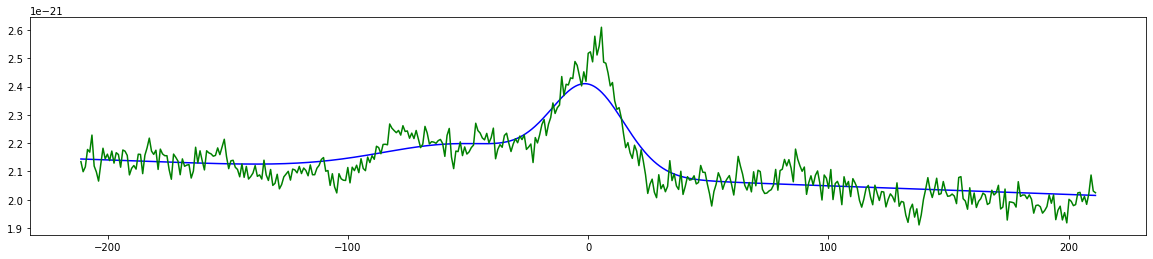

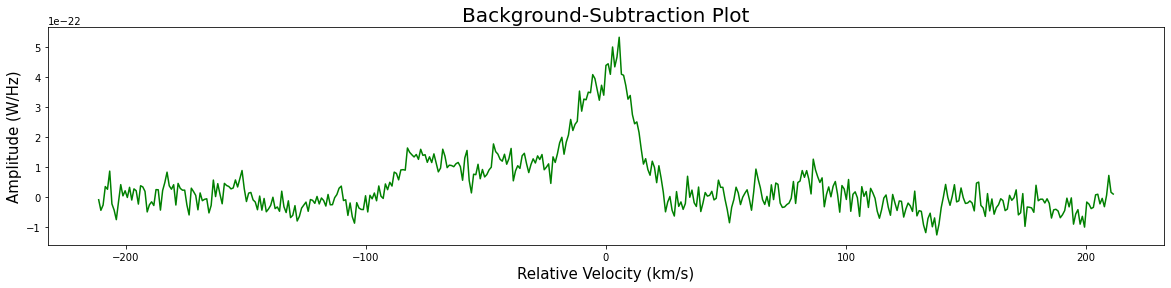

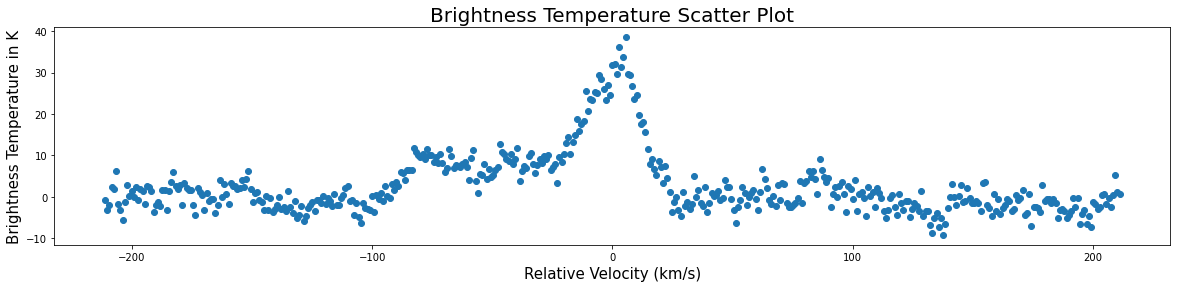

<SkyCoord (Galactic): (l, b) in deg
    (76.90399553, -2.13545804)>
-----------------------------------------------------------------------------------------------------------------
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (308.78022152, 36.9061117)>
-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------
The column density is 2.2550475416503758e+21 nH in cm^(-2)
The column density from the NASA database is 6.9e+21 nH in cm^2
The loss factor in our data is 3.0
-----------------------------------------------------------------------------------------------------------------


In [57]:
#Reading the Data file using Pandas. 
df = pd.read_csv('/Users/shashank/111018.csv', skiprows = 11)
temp_x = np.array(df['Frequecncy(Hz)'])
temp_y = np.array(df['Amplitude(dBm)'])

#Instrumental factors 
y_1 = temp_y - LNA + CableAtten 
#unit conversion to W
y_2 = (10**(y_1/10))/1000 * 2  #conversion and accounting for polarization
#unit conversion to W/Hz
y   = y_2/RBW

#Frequency to Relative Line of Site velocity 
#Flips the axis (therefore a negatively sloping linear is used)
x = -c* ((temp_x/f0)-1)

#finding dy
subset = y[:167]
dy = y*0 + np.std(subset, ddof =1)

#Guess parameters
#Overall linear decline
offset            = (y[460]+y[0])/2
slope             = -np.std(subset)/len(subset)
#order of parameters: 
amplitude_left    = 9 * 10**(-21)                 #in W/Hz
width_left        = 35                            #in km/s
center_left       = -50                           #in km/s
#Gaussian middle
amplitude_right  = 11 * 10 **(-21)                 #in W/Hz
width_right      = 15                             #in km/s
center_right     = 0                              #in km/s

#Guess parameters array
gparams = np.array([offset, slope,
                    amplitude_left, width_left, center_left, 
                    amplitude_right, width_right, center_right])

fit_and_plot(x,y,dy,radiofit,gparams,plot_xlabel,plot_ylabel)

xsmooth = np.linspace(np.min(x), np.max(x), 1000)
fsmooth = radiofit(xsmooth,*gparams)
plt.plot(xsmooth, fsmooth, color = 'b')
plt.plot(x, y, color = 'g')
plt.show()

#background subtraction
background = gparams
background[2] = 0.0
background[5] = 0.0
background_fit = radiofit(x, *background)
corrected_y = y - background_fit     
plt.plot(x, corrected_y, color = 'g')
plt.xlabel(plot_xlabel, fontsize = '15')
plt.ylabel(plot_ylabel, fontsize = '15')
plt.title("Background-Subtraction Plot", fontsize = '20') 
plt.show()

#brightness temperature
T = corrected_y/(2*k_B*B)
plt.scatter(x, T)
plt.xlabel(plot_xlabel, fontsize = '15')
plt.ylabel("Brightness Temperature in K", fontsize = '15')
plt.title("Brightness Temperature Scatter Plot", fontsize = '20')
plt.show()

#Calulating Declination and Right Ascension of where the antennae is pointing
utcoffset = -8 * u.hour
t = Time('2022-11-10 17:23:30') - utcoffset #The time is the middle of the five-minute window of collecting this data file
ucsc = coord.EarthLocation(lat=36.9881*u.deg,lon=-122.0582*u.deg)
thepoint = coord.SkyCoord(alt = 90*u.degree, az = 180*u.degree, obstime = t, frame = 'altaz', location = ucsc)
print(thepoint.galactic)
print ('-----------------------------------------------------------------------------------------------------------------')
print(thepoint.fk5) 
print ('-----------------------------------------------------------------------------------------------------------------')

#Column density
column_density = 0
for i in range(460):
    column_density = column_density + (T[i] * np.abs(x[i+1] - x[i]))
column_density = column_density + (T[460]*(x[460]-x[459]))
column_density = column_density*(1.8224 * 10**18)
print ('-----------------------------------------------------------------------------------------------------------------')
print (f'The column density is {column_density} nH in cm^(-2)')

#FROM NASA at the RA and Dec calculated before
NASA_column_density  =  6.9* 10**(+21)
print (f'The column density from the NASA database is {NASA_column_density} nH in cm^2' )
#Checking to see if there is an integer-like factor, that might account for losses
print (f'The loss factor in our data is {np.round(NASA_column_density/column_density)}')
print ('-----------------------------------------------------------------------------------------------------------------')